In [ ]:
%pip install scikit-learn imbalanced-learn==0.11.0
%pip install matplotlib
%pip install seaborn
%pip install mlflow dagshub
%pip install xgboost

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import warnings
import dagshub
import mlflow

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import *

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ieee-fraud-detection/sample_submission.csv
/kaggle/input/ieee-fraud-detection/test_identity.csv
/kaggle/input/ieee-fraud-detection/train_identity.csv
/kaggle/input/ieee-fraud-detection/test_transaction.csv
/kaggle/input/ieee-fraud-detection/train_transaction.csv


In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 15)
pd.set_option('display.width', None)
pd.set_option('display.expand_frame_repr', False)

# to ignore warnings in cells
warnings.filterwarnings('ignore')

In [4]:
random_state = 42

def show_na_means(df):
  na_means = df.isna().mean().sort_values(ascending=False)
  print(na_means[na_means > 0])

def get_cat_num_cols(df):
  cat_cols = [col for col in df.columns if df[col].dtype == 'object']
  num_cols = [col for col in df.columns if df[col].dtype != 'object']
  return (cat_cols, num_cols)

In [5]:
df_train_transaction = pd.read_csv("/kaggle/input/ieee-fraud-detection/train_transaction.csv")
df_train_identity = pd.read_csv("/kaggle/input/ieee-fraud-detection/train_identity.csv")

In [6]:
df_train = pd.merge(df_train_transaction, df_train_identity, on="TransactionID", how="left")

In [7]:
df_train.drop('TransactionID', axis=1, inplace=True)

# Train/Test Split

In [8]:
X_train, X_test = train_test_split(df_train, test_size=0.2, random_state=random_state)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

y_train = X_train.pop('isFraud')
y_test = X_test.pop('isFraud')

# Preprocessing

## Handling NaNs

In [9]:
class SimpleNAPreprocessor(BaseEstimator, TransformerMixin):
  """Fills NaNs with mode for categorical columns and with median for numerical columns."""

  def __init__(self):
    super().__init__()

  def fit(self, X, y):
    X_work = X.copy()

    self.cat_cols, self.num_cols = get_cat_num_cols(X_work)

    self.cat_cols_modes = {}
    for catcol in self.cat_cols:
      self.cat_cols_modes[catcol] = X_work[catcol].mode().iloc[0]
    
    self.num_cols_medians = {}
    for numcol in self.num_cols:
      self.num_cols_medians[numcol] = X_work[numcol].median()
    
    return self

  def transform(self, X):
    X_work = X.copy()

    # fill categorical missing values with mode
    for catcol in self.cat_cols:
      X_work.fillna({catcol: self.cat_cols_modes[catcol]}, inplace=True)

    # fill numerical missing values with median
    for numcol in self.num_cols:
      X_work.fillna({numcol: self.num_cols_medians[numcol]}, inplace=True)

    return X_work

## Categoric to Numeric Conversions

In [10]:
class EncoderPreprocessor(BaseEstimator, TransformerMixin):
    """Performs WoE and One-Hot Encoding."""
    
    def __init__(self, onehot_threshold: int, onehot_prefix: str):
        self.onehot_prefix = onehot_prefix
        self.onehot_threshold = onehot_threshold

    def fit(self, X, y):
        cat_cols, _ = get_cat_num_cols(X)

        nuniques = X[cat_cols].nunique()
        self.onehot_columns = list(nuniques[nuniques <= self.onehot_threshold].index)
        self.woe_columns = list(nuniques[nuniques > self.onehot_threshold].index)

        self.woe_columns_fill_na = X[self.woe_columns].mode().T[0].to_dict()

        df_woe = X.copy()
        target_col = 'target'
        df_woe[target_col] = y

        self.woe_mappings = {}
        self.iv_values = {}
        
        for col in self.woe_columns:
            groups = df_woe.groupby([col])[target_col].agg(['count', 'sum'])
            groups.columns = ['n_obs', 'n_pos']
            groups['n_neg'] = groups['n_obs'] - groups['n_pos']
      
            groups['prop_pos'] = groups['n_pos'] / groups['n_pos'].sum()
            groups['prop_neg'] = groups['n_neg'] / groups['n_neg'].sum()
      
            groups['woe'] = np.log(groups['prop_pos'] / groups['prop_neg'])
            groups['iv'] = (groups['prop_pos'] - groups['prop_neg']) * groups['woe']
      
            groups.replace([np.inf, -np.inf], 0, inplace=True)
            groups.fillna(0, inplace=True)
      
            woe_dict = groups['woe'].to_dict()
            iv = groups['iv'].sum()
      
            self.woe_mappings[col] = woe_dict
            self.iv_values[col] = iv

        # store expected onehot columns
        df_onehot = pd.get_dummies(X[self.onehot_columns], columns=self.onehot_columns, drop_first=True, dummy_na=True, dtype=int)
        self.expected_onehot_columns = df_onehot.columns.tolist()

        return self

    def transform(self, X):
        X_work = X.copy()

        # Preprocess WOE Columns
        for col in self.woe_columns:
            X_work[f'{col}_woe'] = X_work[col].map(self.woe_mappings[col])
            X_work.drop(columns=col, inplace=True)
        
        # apply One-Hot Encoding
        df_dummy = pd.get_dummies(X_work, columns=self.onehot_columns, drop_first=True, dummy_na=True, dtype=int, prefix=self.onehot_prefix)

        # categories in train but not in test
        missing_cols = set(self.expected_onehot_columns) - set(df_dummy.columns)
        for col in missing_cols:
            df_dummy[col] = 0
        
        # categories in test but not in train
        extra_cols = set(df_dummy.columns) - set(self.expected_onehot_columns) - set(X_work.columns)
        if extra_cols:
            df_dummy = df_dummy.drop(columns=list(extra_cols))

        # maintain order
        common_cols = list(set(X_work.columns) - set(self.onehot_columns))
        X_work = df_dummy[common_cols + self.expected_onehot_columns]

        n = X_work.isna().mean()

        na_cols = list(n[n > 0].index)

        for col in na_cols:
            col_splitted = col.split("_")
            pr = col_splitted[-1]
            name = '_'.join(col_splitted[:-1])
            if pr != "woe":
                print("Error Related to Nans")

            dic = self.woe_columns_fill_na
            mappings = self.woe_mappings
            X_work[col] = X_work[col].fillna(mappings[name][dic[name]])

        return X_work

## Correlation Filter

In [11]:
class CorrelationFilterPreprocessor(BaseEstimator, TransformerMixin):
  """Removes features with correlation higher than given threshold."""

  def __init__(self, correlation_threshold: float, onehot_prefix: str, transaction_dt_column_name: str):
    self.onehot_prefix = onehot_prefix
    self.correlation_threshold = correlation_threshold
    self.transaction_dt_column_name = transaction_dt_column_name
  
  def fit(self, X, y):
    X_work = X.copy()

    correlation_columns = [col for col in X_work.columns if self.onehot_prefix not in col]

    correlation_columns = list(set(correlation_columns))

    X_work = X_work[correlation_columns]

    corr_matrix = X_work.corr().abs()
    pairs = []

    for i in range(len(corr_matrix.columns)):
      for j in range(i+1, len(corr_matrix.columns)):
        if corr_matrix.iloc[i, j] > self.correlation_threshold:
          col_i = corr_matrix.columns[i]
          col_j = corr_matrix.columns[j]

          pairs.append((col_i, col_j, corr_matrix.iloc[i, j]))
    
    temp_target_name = 'isFraud'
    X_work[temp_target_name] = y

    # sort by correlation coefficients
    pairs.sort(key=lambda x: x[2], reverse=True)

    # print(pairs)
    
    self.features_to_drop = set()
    for feat1, feat2, _ in pairs:
      if feat1 in self.features_to_drop or feat2 in self.features_to_drop:
        # if one of them was already marked
        continue
      
      if abs(X_work[feat1].corr(X_work[temp_target_name])) < abs(X_work[feat2].corr(X_work[temp_target_name])):
        self.features_to_drop.add(feat1)
      else:
        self.features_to_drop.add(feat2)

    if self.transaction_dt_column_name in self.features_to_drop:
        self.features_to_drop.remove(self.transaction_dt_column_name)
    
    print(f'Dropping total of {len(self.features_to_drop)} features: {self.features_to_drop}')
    
    return self

  def transform(self, X):
    X_work = X.copy()

    X_work.drop(list(self.features_to_drop), axis=1, inplace=True)

    # print(f'Final number of features: {len(X_work.columns)}')

    return X_work

## Feature Engineering

In [12]:
class FeatureEngineeringPreprocessor(BaseEstimator, TransformerMixin):

  def __init__(self, transaction_dt_column_name: str, features_to_drop: list[str]):
    self.transaction_dt_column_name = transaction_dt_column_name
    self.features_to_drop = features_to_drop
  
  def fit(self, X, y):
    return self

  def transform(self, X):
    X_work = X.copy()

    seconds = X_work[self.transaction_dt_column_name]
    X_work['hour_of_day'] = (seconds // (60 * 60)) % 24
    X_work['day_of_week'] = (seconds // (24 * 60 * 60)) % 7
    X_work['is_weekend'] = X_work['day_of_week'].isin([5,6]).astype(int)

    X_work.drop(self.transaction_dt_column_name, axis=1, inplace=True)

    X_work.drop(self.features_to_drop, axis=1, inplace=True, errors="ignore")

    return X_work

## Custom Standard Scaler

In [13]:
class CustomStandardScaler(BaseEstimator, TransformerMixin):
  def __init__(self):
    self.scaler = StandardScaler()

  def fit(self, X, y):
    self.scaler.fit(X, y)
    return self

  def transform(self, X):
    X_work = X.copy()

    output = self.scaler.transform(X_work)
    df_output = pd.DataFrame(output, columns=self.scaler.feature_names_in_)

    return df_output

# Training

## Feature Selection Phase

In [14]:
onehot_prefix = "onehott"
transaction_dt_column_name = "TransactionDT"
features_to_drop = ['TransactionID']

steps = [
    ('na_filler', SimpleNAPreprocessor()),
    ('encoder', EncoderPreprocessor(onehot_threshold=3, onehot_prefix=onehot_prefix)),
    ('correlation_filter', CorrelationFilterPreprocessor(correlation_threshold=0.8, onehot_prefix=onehot_prefix, transaction_dt_column_name=transaction_dt_column_name)),
    ('feature_engineer', FeatureEngineeringPreprocessor(transaction_dt_column_name=transaction_dt_column_name, features_to_drop=features_to_drop)),
    ('scaler', CustomStandardScaler()),
    ('undersampler', RandomUnderSampler(random_state=42, sampling_strategy=0.33)),
    ('model', RandomForestClassifier(
        n_estimators=500,
        max_depth=5,
        min_samples_leaf=5,
        random_state=random_state,
        max_features="sqrt"
    ))
]

imb_pipeline_with_undersampler = ImbPipeline(steps=steps)
imb_pipeline_with_undersampler.fit(X_train, y_train)

Dropping total of 219 features: {'V316', 'V177', 'V224', 'V304', 'V193', 'V93', 'V145', 'V151', 'V144', 'C7', 'V34', 'V217', 'V96', 'V126', 'V54', 'V336', 'V196', 'V308', 'V321', 'V254', 'V25', 'V51', 'V64', 'V136', 'V297', 'V275', 'V186', 'V339', 'V318', 'V248', 'V238', 'V229', 'V70', 'V60', 'V13', 'V313', 'V148', 'C5', 'V265', 'V324', 'V192', 'V221', 'V179', 'V307', 'V323', 'V269', 'D2', 'V160', 'V246', 'V183', 'V333', 'V161', 'C1', 'V167', 'V204', 'V100', 'V11', 'V291', 'V252', 'V135', 'V152', 'V36', 'V188', 'V233', 'V103', 'V21', 'V81', 'V298', 'V142', 'C4', 'V331', 'V49', 'V133', 'V274', 'V207', 'V116', 'V127', 'V322', 'V7', 'V104', 'V95', 'V198', 'V42', 'V43', 'V58', 'V332', 'V164', 'V272', 'V219', 'V50', 'V94', 'V139', 'V189', 'V143', 'V79', 'V105', 'V33', 'V146', 'C6', 'V306', 'V278', 'V206', 'V259', 'V66', 'V182', 'V190', 'V82', 'V303', 'V292', 'V242', 'V80', 'V237', 'V317', 'V314', 'V74', 'V270', 'V39', 'V30', 'V129', 'C10', 'V280', 'V31', 'V200', 'V24', 'V264', 'V261', 'V134

Pipeline(steps=[('na_filler', SimpleNAPreprocessor()),
                ('encoder',
                 EncoderPreprocessor(onehot_prefix='onehott',
                                     onehot_threshold=3)),
                ('correlation_filter',
                 CorrelationFilterPreprocessor(correlation_threshold=0.8,
                                               onehot_prefix='onehott',
                                               transaction_dt_column_name='TransactionDT')),
                ('feature_engineer',
                 FeatureEngineeringPreprocessor(features_to_drop=['TransactionID'],
                                                transaction_dt_column_name='TransactionDT')),
                ('scaler', CustomStandardScaler()),
                ('undersampler',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.33)),
                ('model',
                 RandomForestClassifier(max_depth=5, min_samples_leaf=5,
                                        n_estimators=500, random_state=42))])

In [15]:
steps_without_undersampler = [(name, step) for name, step in imb_pipeline_with_undersampler.steps if name not in ('undersampler', 'model')]
imb_pipeline_without_undersampler = ImbPipeline(steps=steps_without_undersampler)

In [16]:
X_train_transformed = imb_pipeline_without_undersampler.transform(X_train)
transformed_feature_names = imb_pipeline_with_undersampler['scaler'].scaler.feature_names_in_

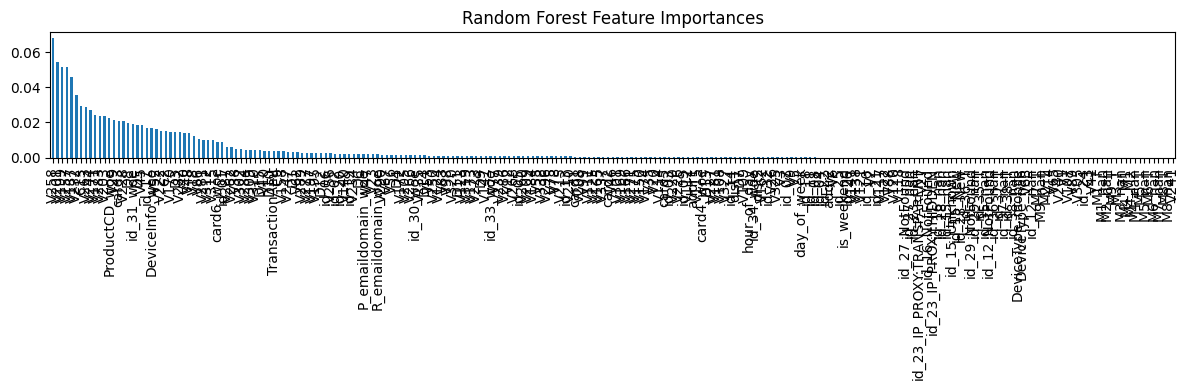

In [17]:
rf = imb_pipeline_with_undersampler['model']
feature_importance = pd.Series(rf.feature_importances_, index=transformed_feature_names).sort_values(ascending=False)
feature_importance.plot(kind="bar", figsize=(12, 4), title="Random Forest Feature Importances")
plt.tight_layout()
plt.show()

In [18]:
df_feature_importance = pd.DataFrame(feature_importance, columns=['importance'])

# Calculate cumulative importance
df_feature_importance['cumulative_importance'] = df_feature_importance['importance'].cumsum()

# Find top features needed to reach 95% of total importance
important_features = df_feature_importance[df_feature_importance['cumulative_importance'] <= 0.95]
print(f"Number of features to keep: {len(important_features)} out of {len(df_feature_importance)}")

selected_features = set(important_features.index)

Number of features to keep: 71 out of 239


In [19]:
class FeatureSelector(BaseEstimator, TransformerMixin):
  def __init__(self, selected_features: set[str]):
    self.selected_features = selected_features
  
  def fit(self, X, y):
    return self

  def transform(self, X):
    X_work = X.copy()
    X_work = X_work[list(self.selected_features)]
    return X_work

## Training Phase

In [20]:
feature_selector = FeatureSelector(selected_features=selected_features)

final_steps = [
    ('undersampler', RandomUnderSampler(random_state=random_state, sampling_strategy=0.33)),
    ('model', RandomForestClassifier(
        n_estimators=500,
        max_depth=5,
        min_samples_leaf=5,
        random_state=random_state,
        max_features="sqrt",
        class_weight="balanced"
    ))
]
final_pipeline = ImbPipeline(steps=final_steps)

X_train_final = feature_selector.fit_transform(X_train_transformed, y_train)
final_pipeline.fit(X_train_final, y_train)

Pipeline(steps=[('undersampler',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.33)),
                ('model',
                 RandomForestClassifier(class_weight='balanced', max_depth=5,
                                        min_samples_leaf=5, n_estimators=500,
                                        random_state=42))])

In [68]:
steps_to_log = [(name, step) for name, step in imb_pipeline_with_undersampler.steps if name not in ('undersampler', 'model')]
steps_to_log += [('feature_selector', feature_selector)]
steps_to_log += [(name, step) for name, step in final_pipeline.steps]

pipeline_to_log = ImbPipeline(steps_to_log)

# MLFlow Tracking

In [69]:
import dagshub
dagshub.init(repo_owner='b3tameche', repo_name='kaggle-fraud-detection', mlflow=True)

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=5d76e5e6-f645-4440-bbf6-6a9e32dcd3e1&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=d72c37344d7a8bd3e618eef6c9335af2662039cb453a84e5fab3bebc738a6afc




Output()

Accessing as b3tameche

Initialized MLflow to track repo "b3tameche/kaggle-fraud-detection"

Repository b3tameche/kaggle-fraud-detection initialized!

## Cleaning Phase

In [73]:
# Retrieve Cleaning Objects
log_na_filler = steps_to_log[0][1]
log_encoder = steps_to_log[1][1]
log_correlation_filter = steps_to_log[2][1]
log_feature_engineer = steps_to_log[3][1]
log_custom_standard_scaler = steps_to_log[4][1]

In [75]:
experiment_name = "RandomForest_Training"
cleaning_run_name = "RandomForest_Cleaning"

mlflow.set_experiment(experiment_name)

with mlflow.start_run(run_name=cleaning_run_name):
    mlflow.log_param("na_filler_cat_cols_modes", log_na_filler.cat_cols_modes)
    mlflow.log_param("na_filler_num_cols_medians", log_na_filler.num_cols_medians)

    mlflow.log_param("encoder_woe_columns", log_encoder.woe_columns)
    mlflow.log_param("encoder_onehot_columns", log_encoder.onehot_columns)
    mlflow.log_param("encoder_expected_onehot_columns", log_encoder.expected_onehot_columns)

    mlflow.log_param("correlation_filter_features_to_drop", log_correlation_filter.features_to_drop)

2025/04/22 00:15:18 INFO mlflow.tracking.fluent: Experiment with name 'RandomForest_Training' does not exist. Creating a new experiment.


🏃 View run RandomForest_Cleaning at: https://dagshub.com/b3tameche/kaggle-fraud-detection.mlflow/#/experiments/2/runs/15ede4030d494a09934c962846ba37c6
🧪 View experiment at: https://dagshub.com/b3tameche/kaggle-fraud-detection.mlflow/#/experiments/2


## Feature Selection Phase

In [76]:
# Retrieve Feature Selection objects
log_feature_selector = steps_to_log[5][1]

In [78]:
experiment_name = "RandomForest_Training"
feature_selection_run_name = "RandomForest_Feature_Selection"

mlflow.set_experiment(experiment_name)

with mlflow.start_run(run_name=feature_selection_run_name):
    mlflow.log_param("feature_selection_selected_features", log_feature_selector.selected_features)

🏃 View run RandomForest_Feature_Selection at: https://dagshub.com/b3tameche/kaggle-fraud-detection.mlflow/#/experiments/2/runs/cd081ea43eeb48d9824e50362decaa94
🧪 View experiment at: https://dagshub.com/b3tameche/kaggle-fraud-detection.mlflow/#/experiments/2


## Training Phase (Log)

In [80]:
log_undersampler = steps_to_log[6][1]
log_random_forest_model = steps_to_log[7][1]

# make predictions
pred_train = final_pipeline.predict(X_train_final)

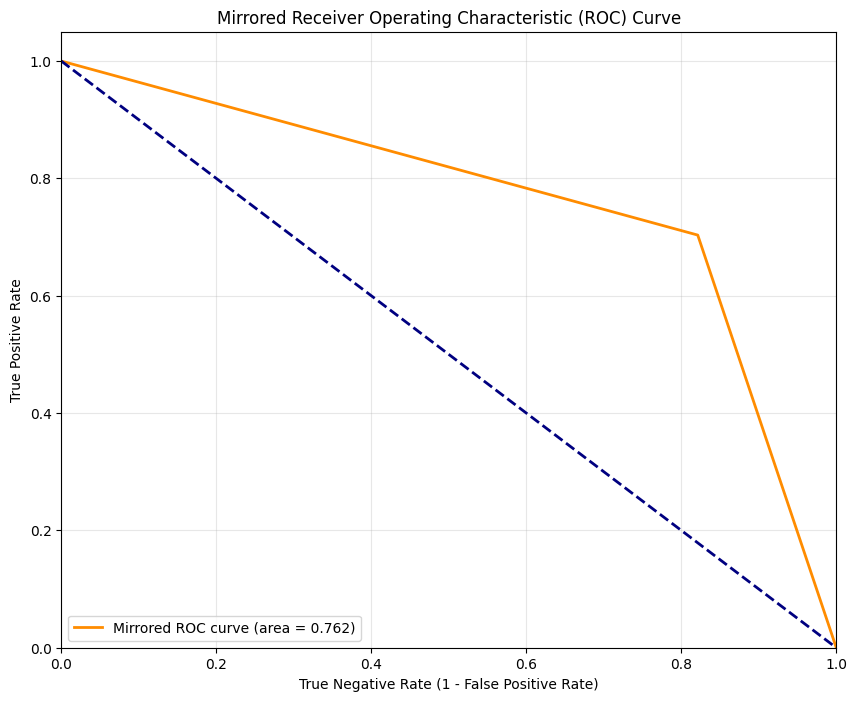

In [81]:
# Evaluate metrics

# [[True Negative, False Positive],
#  [False Negative, True Positive]]
conf_matrix = confusion_matrix(y_train, pred_train)
conf_matrix_dict = {
    "TN": conf_matrix[0][0],
    "FP": conf_matrix[0][1],
    "FN": conf_matrix[1][0],
    "TP": conf_matrix[1][1]
}

classification_report_dict = classification_report(y_train, pred_train, output_dict=True)

# ROC curve
fpr, tpr, thresholds = roc_curve(y_train, pred_train)
roc_auc = auc(fpr, tpr)

tnr = 1 - fpr

plt.figure(figsize=(10, 8))

plt.plot(tnr, tpr, color='darkorange', lw=2, 
         label=f'Mirrored ROC curve (area = {roc_auc:.3f})')

# Plot diagonal line (represents random classifier)
plt.plot([0, 1], [1, 0], color='navy', lw=2, linestyle='--')

# Set plot properties
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('True Negative Rate (1 - False Positive Rate)')
plt.ylabel('True Positive Rate')
plt.title('Mirrored Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower left")

# Display the plot
plt.grid(alpha=0.3)

plt.savefig("RandomForest_ROC_Curve.png")

In [82]:
experiment_name = "RandomForest_Training"
training_run_name = "RandomForest_Training"

mlflow.set_experiment(experiment_name)

with mlflow.start_run(run_name=training_run_name):
    mlflow.log_param("undersampler_sampling_strategy", log_undersampler.sampling_strategy)
    mlflow.log_param("rf_n_estimators", log_random_forest_model.n_estimators)
    mlflow.log_param("rf_max_depth", log_random_forest_model.max_depth)
    mlflow.log_param("rf_min_samples_leaf", log_random_forest_model.min_samples_leaf)
    mlflow.log_param("rf_random_state", log_random_forest_model.random_state)
    mlflow.log_param("rf_max_features", log_random_forest_model.max_features)
    mlflow.log_param("rf_class_weight", log_random_forest_model.class_weight)

    mlflow.log_dict(conf_matrix_dict, "confusion_matrix.json")
    mlflow.log_dict(classification_report_dict, "classification_report.json")

    mlflow.log_artifact("RandomForest_ROC_Curve.png")

    mlflow.sklearn.log_model(pipeline_to_log, "pipeline_RandomForest")

2025/04/22 00:32:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForest_Training at: https://dagshub.com/b3tameche/kaggle-fraud-detection.mlflow/#/experiments/2/runs/c7a713f7a2a648629bae4a2166602d11
🧪 View experiment at: https://dagshub.com/b3tameche/kaggle-fraud-detection.mlflow/#/experiments/2
